In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from skimage.transform import resize, rotate
import pandas as pd
import os as os
from src import transform_image
from PIL import Image
from sklearn import decomposition, datasets
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans

In [2]:
#list of ruled and unruled images to check length for imbalanced classes

ruled_dir = "images/Ruled"
unruled_dir = 'images/Unruled'

ruled_images = []
unruled_images = []

for file in os.listdir(ruled_dir):
    ruled_images.append(file)

for file in os.listdir(unruled_dir):
    unruled_images.append(file)

In [3]:
len(ruled_images), len(unruled_images)

(454, 669)

### Question! Ruled images =454, Unruled images = 669 .....Do i need to worry about imbalanced classes? (dont think so due to unsupervised learning??)


## Notes: 

dont need to worry about imbalance until 80/20

In [4]:
#using PIL to open images
file_name = os.path.join(ruled_dir, 'IMG_0003.jpg')
sketch_grey = np.array(Image.open(file_name)) 

In [5]:
print('Type: {}'.format(type(sketch_grey)))
print('Shape: {}'.format(sketch_grey.shape))

Type: <class 'numpy.ndarray'>
Shape: (500, 400)


## Now lets try to find the edges and featurize them...using different filters

First Pass:
1. skimage.filters.sobel_h(image[, mask]) - Find the horizontal edges of an image using the Sobel transform.

2. skimage.filters.sobel_v(image[, mask]) - Find the vertical edges of an image using the Sobel transform.

3. filters.sobel

#### Not enough edges to work, lets try more filters...
Second Pass:

4. skimage.filters.rank.bottomhat(image, selem, out=None, mask=None, shift_x=False, shift_y=False)   
    * black top-hat transform is defined dually as the difference between the closing and the input image.

5. skimage.filters.rank.tophat(image, selem, out=None, mask=None, shift_x=False, shift_y=False)

    * white top-hat transform is defined as the difference between the input image and its opening by some structuring element
    * Top-hat transforms are used for various image processing tasks, such as feature extraction, background equalization, image enhancement, and others.

6. skimage.filters.try_all_threshold(image, figsize=(8, 5), verbose=True) 
    * Returns a figure comparing the outputs of different thresholding methods.

7. threshold_multiotsu(image, classes=3, nbins=256)
Generate classes-1 threshold values to divide gray levels in image.
    * The threshold values are chosen to maximize the total sum of pairwise variances between the thresholded graylevel classes.


In [6]:
#create sobel features


sobel_h =filters.sobel_h(sketch_grey)
sobel_v =filters.sobel_v(sketch_grey)
sobel = filters.sobel(sketch_grey)


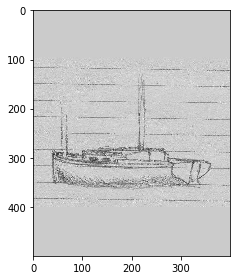

In [7]:
#for presentation
io.imshow(sketch_grey)


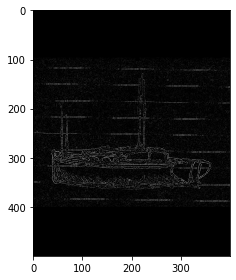

In [8]:
io.imshow(sobel)

Lossy conversion from float64 to uint8. Range [-0.5274509803921569, 0.4882352941176471]. Convert image to uint8 prior to saving to suppress this warning.


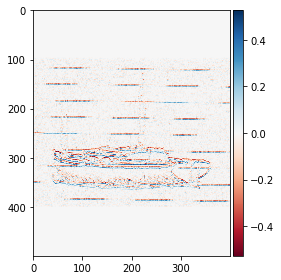

In [9]:
#for presentation
io.imshow(sobel_h);
io.imsave('images/sample_sobel_h.png',sobel_h)

Lossy conversion from float64 to uint8. Range [-0.5284313725490196, 0.4696078431372549]. Convert image to uint8 prior to saving to suppress this warning.


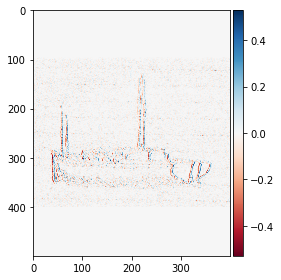

In [10]:
#for presentation
io.imshow(sobel_v);
io.imsave('images/sample_sobel_v.png',sobel_v)

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


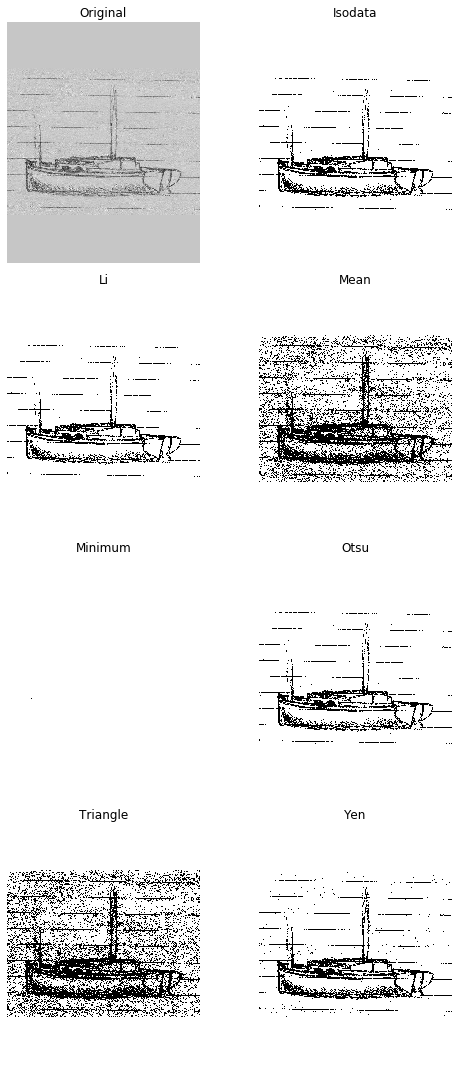

In [11]:
#
filters.try_all_threshold(sketch_grey, figsize=(8, 15), verbose=True); 

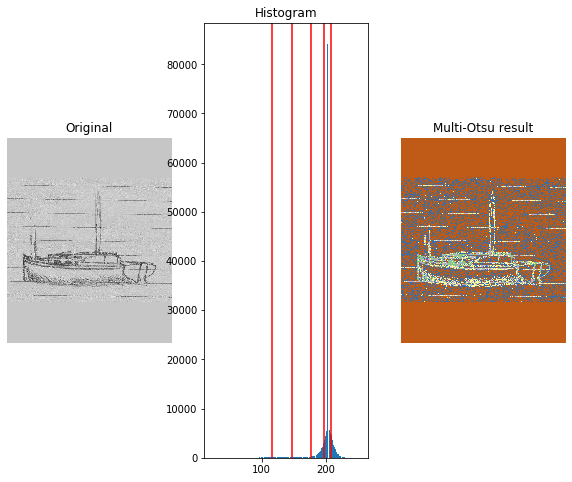

In [22]:
# more filters - ABORTED Tophat/Bottomhat - cant figure out what a selem is? 

# top_hat = filters.rank.tophat(sketch_grey, selem)
# bottom_hat = filters.rank.bottomhat(sketch_grey, selem) 


thresholds = filters.threshold_multiotsu(sketch_grey, classes=6, nbins=256) #cant get above 6 classes

# Using the threshold values, we generate the three regions.
regions = np.digitize(sketch_grey, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 8))

# Plotting the original image.
ax[0].imshow(sketch_grey, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(sketch_grey.ravel(), bins=256)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='Accent')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

In [23]:
regions

array([[4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

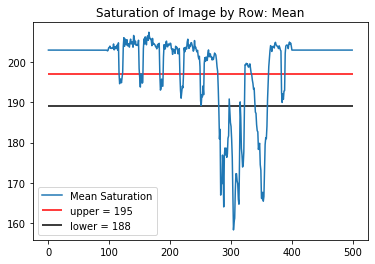

In [165]:
# high values are white, lower the mean of a row the darker the pixels, the 6 spikes below are the 6 background lines 
plt.plot(sketch_grey.mean(axis = 1), label = 'Mean Saturation' ) #across rows
plt.hlines(197, 0, 500, colors='red', linestyles='solid', label='upper = 195')
plt.hlines(189, 0, 500, colors='k', linestyles='solid', label='lower = 188')
plt.title('Saturation of Image by Row: Mean')
plt.legend()

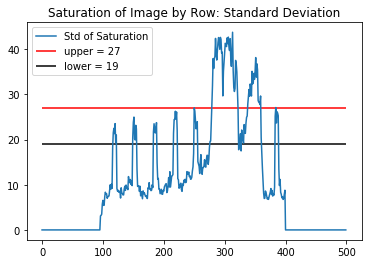

In [164]:
plt.plot(np.std(sketch_grey, axis=1), label = 'Std of Saturation')
plt.hlines(27, 0, 500, colors='red', linestyles='solid', label='upper = 27')
plt.hlines(19, 0, 500, colors='k', linestyles='solid', label='lower = 19')
plt.title('Saturation of Image by Row: Standard Deviation')
plt.legend()

In [91]:
mean_std_df = pd.DataFrame({'y': range(500), 'mean': sketch_grey.mean(axis = 1), 'std': np.mean(sketch_grey, axis =1)})
mean_std_df.head()

,y,mean,std
0,0,203.0,203.0
1,1,203.0,203.0
2,2,203.0,203.0
3,3,203.0,203.0
4,4,203.0,203.0


In [24]:
#NOW Create a data frame with all of the features for that image
#add regular sobel 
x = []
y = []



for i in range(sketch_grey.shape[0]):
    for j in range(sketch_grey.shape[1]):
        x.append(j)
        y.append(i)
        
        #sobel.append(sobel[i,j])
df = pd.DataFrame({
'x':x, 
'y':y,
'grey':sketch_grey.flatten(),
'sobel':sobel.flatten(),
'sobel_h': sobel_h.flatten(),
'sobel_v': sobel_v.flatten(),
'multiotsu': regions.flatten(),
}
)
df

,x,y,grey,sobel,sobel_h,sobel_v,multiotsu
0,0,0,203,0.0,0.0,0.0,4
1,1,0,203,0.0,0.0,0.0,4
2,2,0,203,0.0,0.0,0.0,4
3,3,0,203,0.0,0.0,0.0,4
4,4,0,203,0.0,0.0,0.0,4
...,...,...,...,...,...,...,...
199995,395,499,203,0.0,0.0,0.0,4
199996,396,499,203,0.0,0.0,0.0,4
199997,397,499,203,0.0,0.0,0.0,4
199998,398,499,203,0.0,0.0,0.0,4


In [94]:
#merge
df = df.set_index('y').join(mean_std_df.set_index('y')).reset_index()

In [170]:
#new idea for feature! If you have. adaark pixel on a line thats mostly dark..probably a line, opposite = boat?
df['delta'] = df['grey'] - df['mean']
df['delta'].nunique()

17261

In [171]:
#PCA to remove features and to standardize
#pca = PCA(whiten=True).fit_transform(df[['grey', 'sobel', 'sobel_h', 'sobel_v', 'multiotsu', 'mean', 'std', 'delta']])

# later switched to Standard Scaler...ask Land why??
from sklearn.preprocessing import StandardScaler as SS

ss = SS().fit_transform(df[['grey', 'sobel', 'sobel_h', 'sobel_v', 'multiotsu', 'mean', 'std', 'delta']])


In [173]:
#pca.shape
ss.shape

(200000, 8)

In [174]:
#df['labels'] = KMeans(n_clusters=4).fit(pca).labels_ <---did it all in one line to start
n = 4
cluster = KMeans(n_clusters=n).fit(ss)
df['labels'] = cluster.labels_


In [175]:
df

,y,x,grey,sobel,sobel_h,sobel_v,multiotsu,labels,mean,std,delta
0,0,0,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
1,0,1,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
2,0,2,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
3,0,3,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
4,0,4,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
199995,499,395,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
199996,499,396,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
199997,499,397,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0
199998,499,398,203,0.0,0.0,0.0,4,0,203.0,203.0,0.0


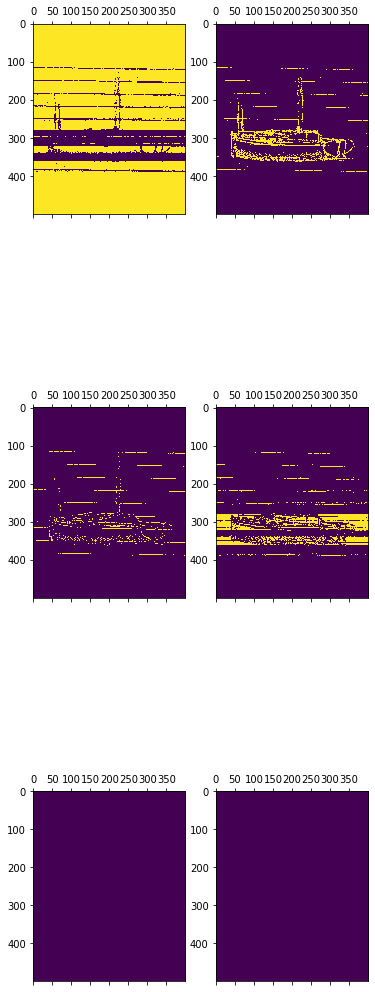

In [176]:
#io.imshow(df['labels'].values.reshape(sketch_grey.shape))
#plt.matshow(df['labels'].values.reshape(sketch_grey.shape))
fig, axs = plt.subplots(3,2, figsize=(6,20))

for i, ax in enumerate(axs.flatten()):
    ax.matshow((df['labels']==i).values.reshape(sketch_grey.shape))
    




In [143]:
#the one with the highest first value will be the background - fill in the background lines with NMF
cluster_centers = cluster.cluster_centers_
cluster_centers

array([[ 1.63258935e-01,  8.75790165e-01,  8.64122609e-01,
        -1.70014159e-01,  1.43857779e-01, -1.91962997e+00,
        -1.91962997e+00],
       [-8.16271329e-01,  2.94591154e+00, -3.03925672e+00,
         1.05595642e+00, -8.77691172e-01, -1.44818920e+00,
        -1.44818920e+00],
       [ 2.48137987e-01, -3.10680473e-01, -1.06812225e-03,
        -3.72058451e-03,  2.28574324e-01,  3.85450470e-01,
         3.85450470e-01],
       [-3.36006482e+00,  1.48907564e+00,  5.77113125e-01,
        -3.30020404e-01, -3.01051335e+00, -1.95660433e+00,
        -1.95660433e+00]])

In [ ]:
#use NMF

In [115]:
# exp_var_ratio = pca.explained_variance_ratio_
# exp_sing_vals = pca.singular_values_

df['labels'].nunique()

3

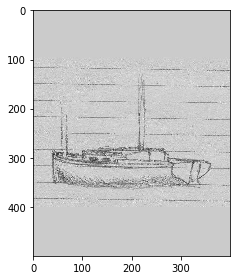

In [95]:
#turn back into an image

new_image = df['grey'].values.reshape(sketch_grey.shape)
io.imshow(new_image)